In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t
from torch import nn, optim
from torch.autograd import Variable
from IPython.display import Audio
from scipy.io import wavfile

class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = t.sparse.torch.eye(depth)
    def forward(self, X_in):
        return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

## Wavenet  class
Two generation functions are included. generate_slow( ) is easy to understand, but generate( ) is much faster.

In [2]:
class WaveNet(nn.Module):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        dilations = self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
        self.one_hot = One_Hot(mu)
        self.from_input = nn.Conv1d(in_channels=mu, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_skip, kernel_size=1)
                         for d in dilations])
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=1)
                         for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        self.conv_post_2 = nn.Conv1d(in_channels=n_skip, out_channels=mu, kernel_size=1)
        
    def forward(self, input):
        output = self.preprocess(input)
        output = output
        skip_connections = [] # save for generation purposes
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
            skip_connections.append(skip)
        # sum up skip connections
        output = sum([s[:,:,-output.size(2):] for s in skip_connections])
        output = self.postprocess(output)
        return output
    
    def preprocess(self, input):
        output = self.one_hot(input).unsqueeze(0).transpose(1,2)
        output = self.from_input(output.cuda())
        return output
    
    def postprocess(self, input):
        output = nn.functional.elu(input)
        output = self.conv_post_1(output)
        output = nn.functional.elu(output)
        output = self.conv_post_2(output).squeeze(0).transpose(0,1)
        return output
    
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = nn.functional.sigmoid(output_sigmoid) * nn.functional.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip
    
    def generate_slow(self, input, n=100):
        res = input.data.tolist()
        for _ in range(n):
            x = Variable(t.LongTensor(res[-sum(self.dilations)-1:]))
            y = self.forward(x)
            _, i = y.max(dim=1)
            res.append(i.data.tolist()[-1])
        return res
    
    def generate(self, input=None, n=100, temperature=None, estimate_time=False):
        ## prepare output_buffer
        output = self.preprocess(input)
        output_buffer = []
        for s, t_, skip_scale, residue_scale, d in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, self.dilations):
            output, _ = self.residue_forward(output, s, t_, skip_scale, residue_scale)
            sz = 1 if d==2**(self.dilation_depth-1) else d*2
            output_buffer.append(output[:,:,-sz-1:-1])
        ## generate new 
        res = input.data.tolist()
        for i in range(n):
            output = Variable(torch.LongTensor(res[-2:]))
            output = self.preprocess(output)
            output_buffer_next = []
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale, b in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, output_buffer):
                output, residue = self.residue_forward(output, s, t, skip_scale, residue_scale)
                output = torch.cat([b, output], dim=2)
                skip_connections.append(residue)
                if i%100==0:
                    output = output.clone()
                output_buffer_next.append(output[:,:,-b.size(2):])
            output_buffer = output_buffer_next
            output = output[:,:,-1:]
            # sum up skip connections
            output = sum(skip_connections)
            output = self.postprocess(output)
            if temperature is None:
                _, output = output.max(dim=1)
            else:
                output = output.div(temperature).exp().multinomial(1).squeeze()
            res.append(output.data[-1])
        return res

## test network forward( )

In [3]:
net = WaveNet(mu=128)
net.cuda()
batch = Variable(torch.from_numpy(np.random.randint(0,128,10000).astype(np.long)))
net(batch)

Variable containing:
 6.8268e-02  3.1182e-01 -3.8851e-02  ...  -5.3135e-02 -2.1308e-01 -1.1641e-01
 3.1336e-02  3.3316e-01 -5.0665e-02  ...  -3.6464e-02 -2.1841e-01 -1.1538e-01
 4.1489e-02  3.1801e-01 -8.1448e-02  ...  -5.0256e-02 -2.2517e-01 -1.1535e-01
                ...                   ⋱                   ...                
 3.7753e-02  3.4527e-01 -5.0369e-02  ...  -2.0527e-02 -2.2325e-01 -7.6358e-02
 1.0124e-03  3.4359e-01 -5.9491e-02  ...  -4.2500e-02 -2.2493e-01 -1.0096e-01
 1.2908e-02  3.2801e-01 -8.6433e-02  ...  -2.6249e-02 -2.1909e-01 -9.2343e-02
[torch.cuda.FloatTensor of size 4885x128 (GPU 0)]

## test generation

- generate_slow( ) is easy to understand
- generate( ) is faster than generate_slow( )

In [4]:
%time y_gen = net.generate(batch, 20)
#%time y_gen2 = net.generate_slow(batch, 20)

CPU times: user 604 ms, sys: 23.6 ms, total: 627 ms
Wall time: 626 ms


In [5]:
y_gen[-5:]
#y_gen2[-5:]

[63, 63, 63, 63, 63]

## $\mu$-law encode and decode

In [6]:
def encode_mu_law(x, mu=256):
    mu = mu-1
    fx = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)

def decode_mu_law(y, mu=256):
    mu = mu-1
    fx = (y-0.5)/mu*2-1
    x = np.sign(fx)/mu*((1+mu)**np.abs(fx)-1)
    return x  

## sine wave generator

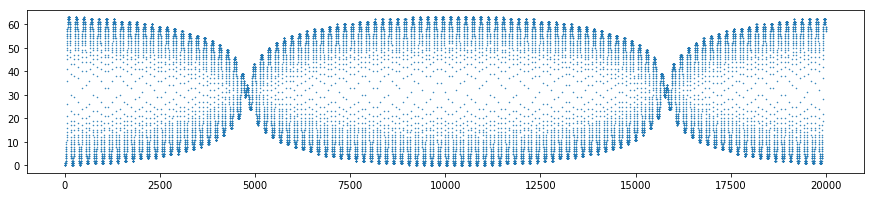

In [7]:
def sine_generator(seq_size = 6000, mu=256):
    framerate = 44100
    t = np.linspace(0,5,framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        ys = encode_mu_law(ys,mu)
        yield Variable(torch.from_numpy(ys[:seq_size]))
        
g = sine_generator(mu=64, seq_size=20000)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(x.data.tolist(),'.', ms=1)

## listen to the signal

In [8]:
y = x.data.numpy()
y = decode_mu_law(y, 64)
Audio(y,rate=44100)

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

epoch 0, loss 4.175650119781494


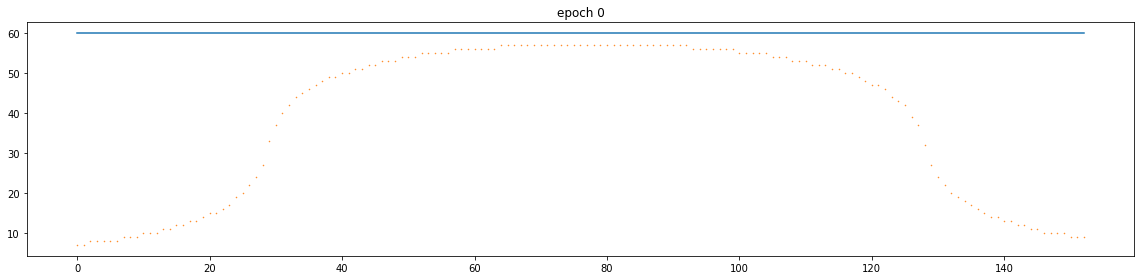

epoch 100, loss 0.30030760169029236


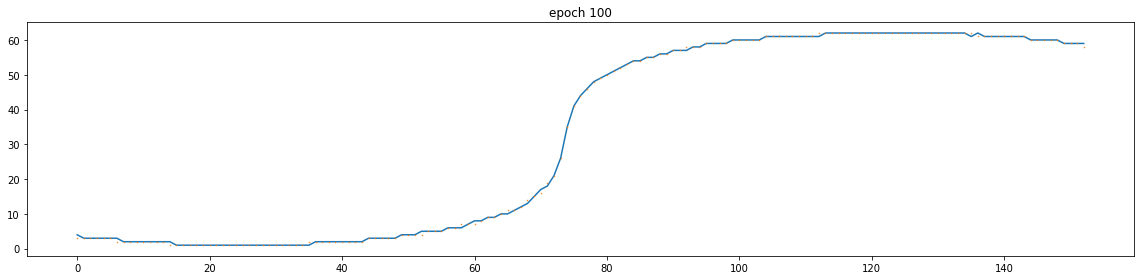

epoch 200, loss 0.19173355400562286


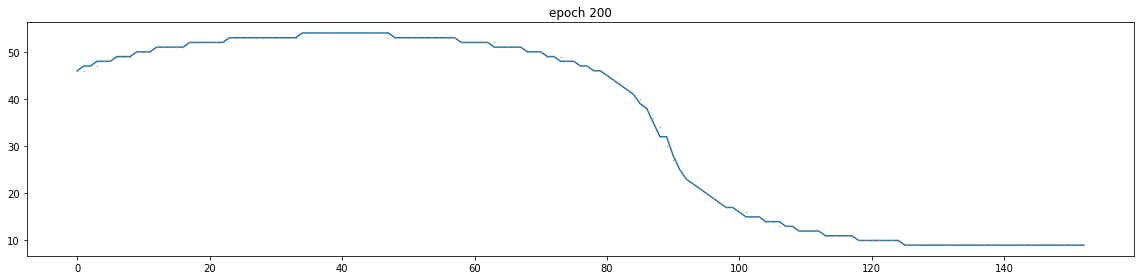

epoch 300, loss 0.14909203350543976


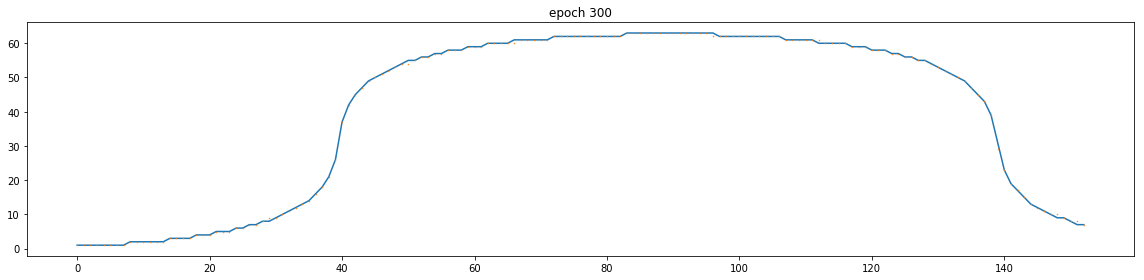

epoch 400, loss 0.11326809972524643


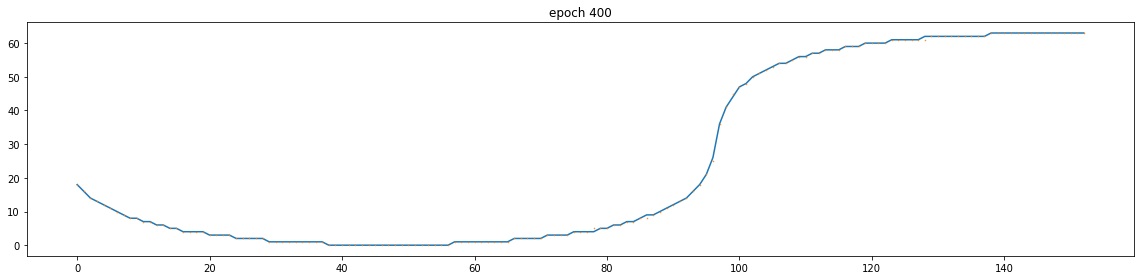

epoch 500, loss 0.1043965145945549


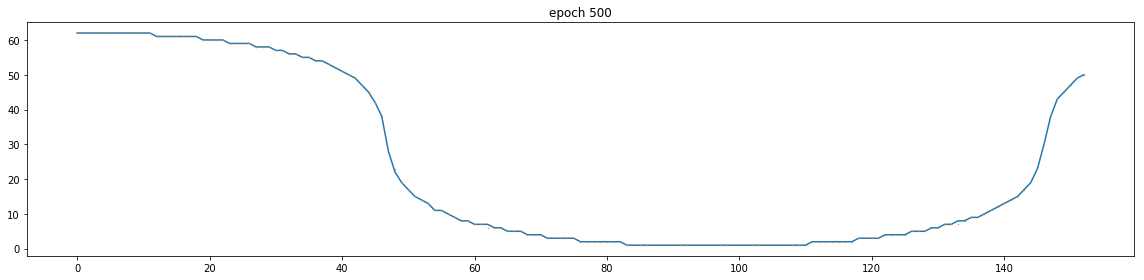

epoch 600, loss 0.09044790267944336


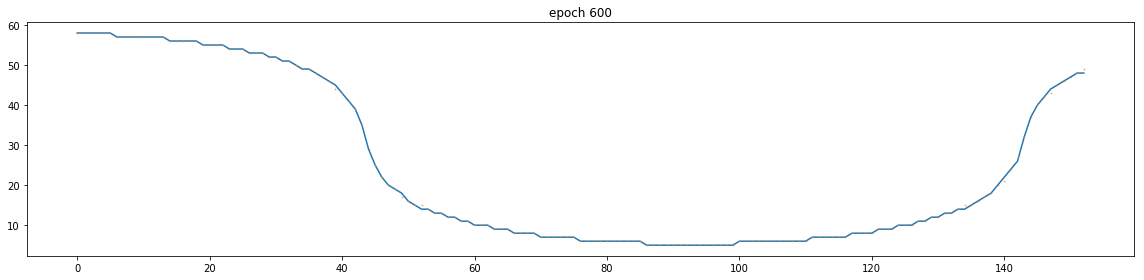

epoch 700, loss 0.09711665660142899


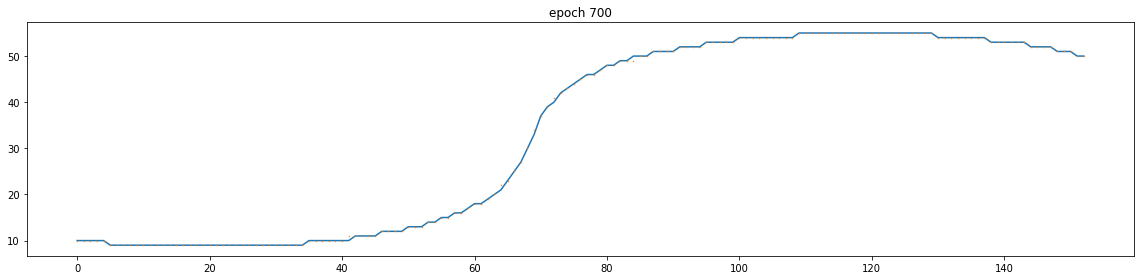

epoch 800, loss 0.07762712985277176


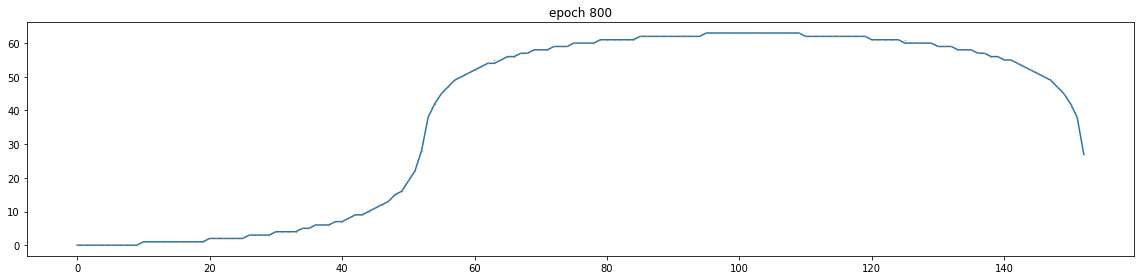

epoch 900, loss 0.07841378450393677


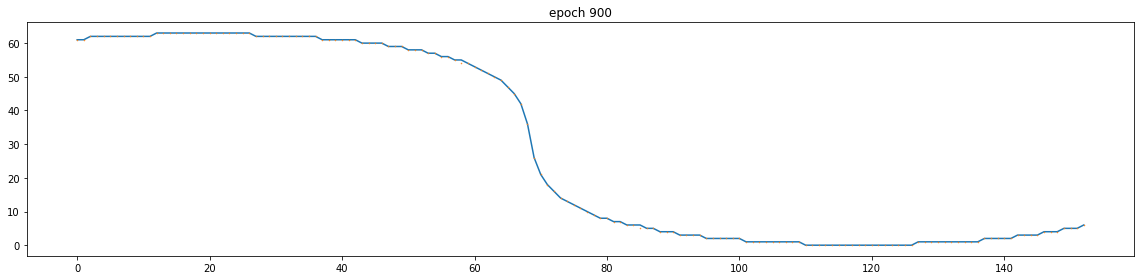

epoch 1000, loss 0.07644079625606537


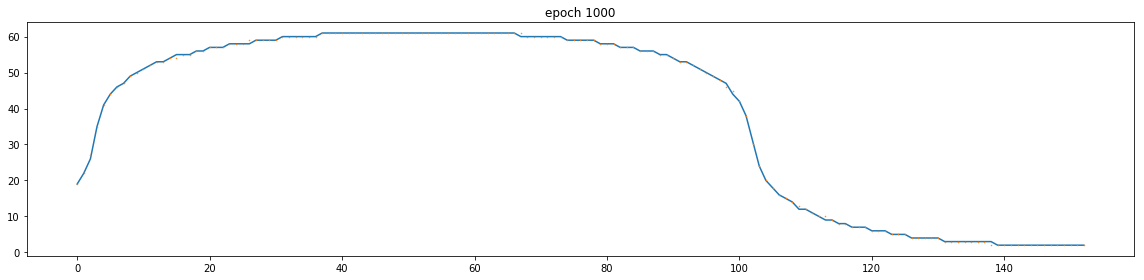

epoch 1100, loss 0.061719220131635666


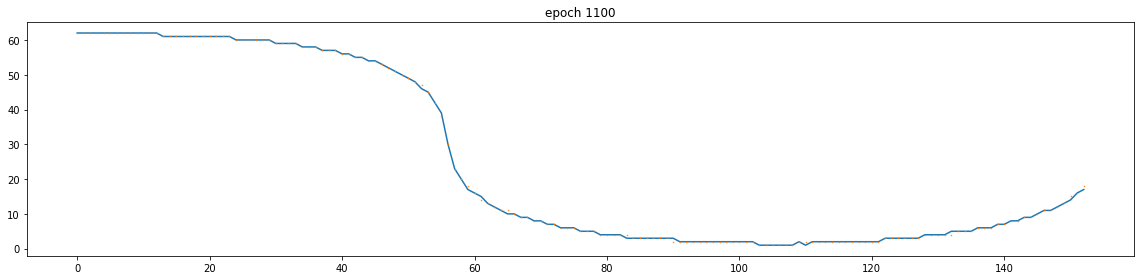

epoch 1200, loss 0.0729505866765976


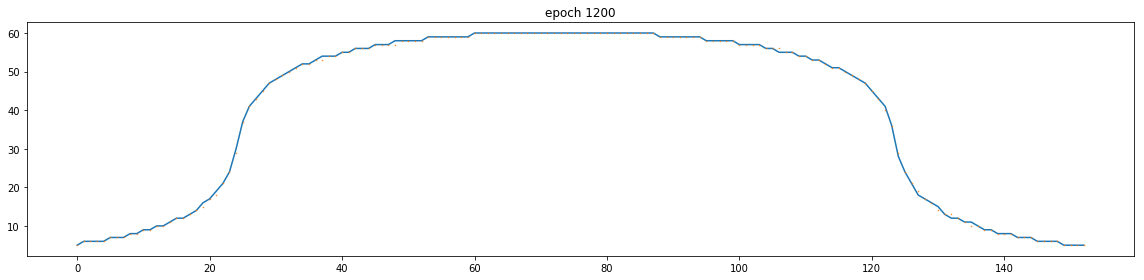

epoch 1300, loss 0.06838095188140869


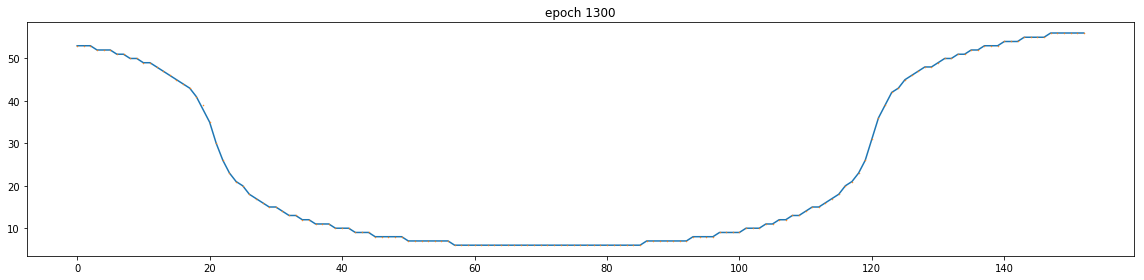

epoch 1400, loss 0.07545669376850128


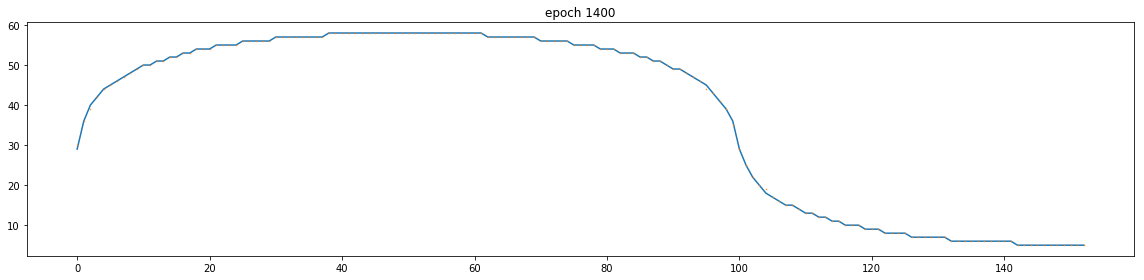

epoch 1500, loss 0.07294920086860657


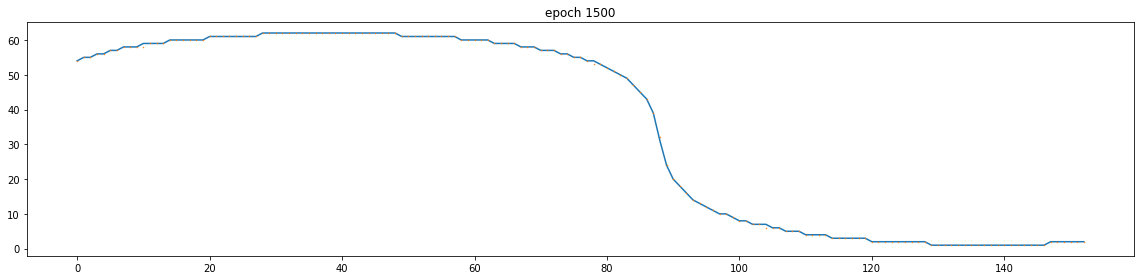

epoch 1600, loss 0.062374528497457504


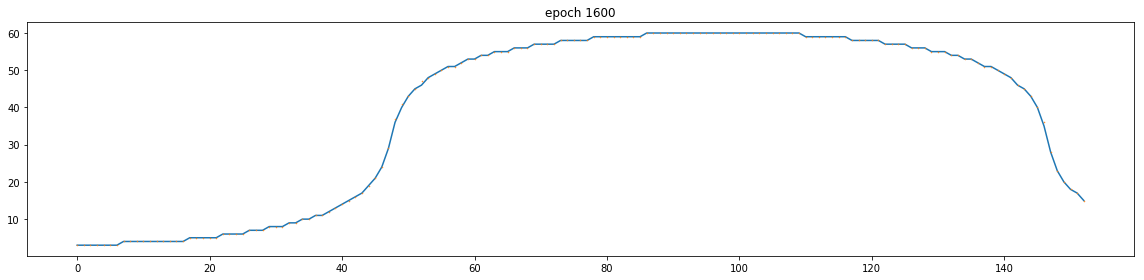

epoch 1700, loss 0.06432060152292252


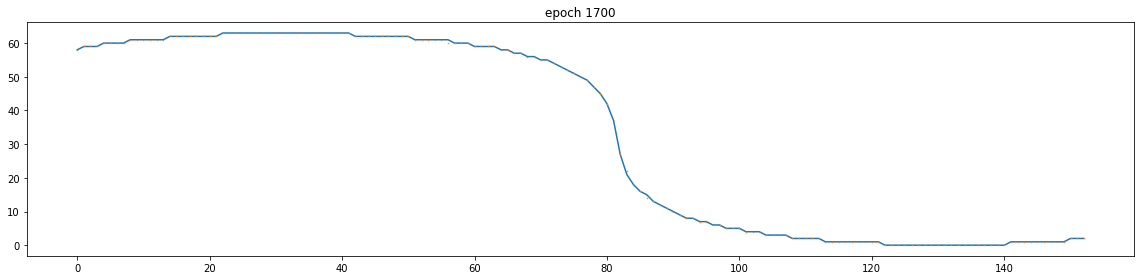

epoch 1800, loss 0.06558182090520859


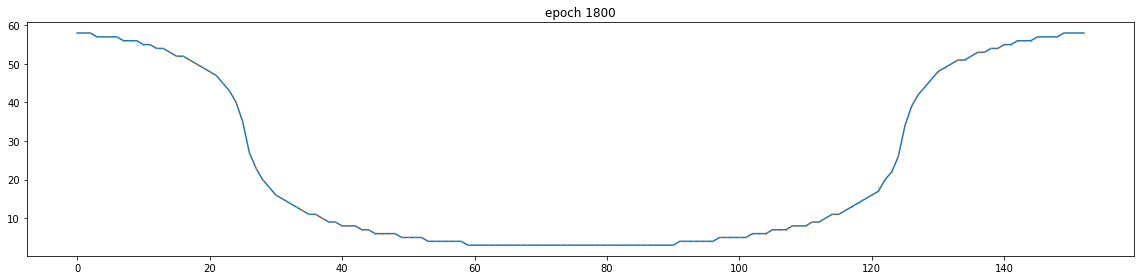

epoch 1900, loss 0.06984151154756546


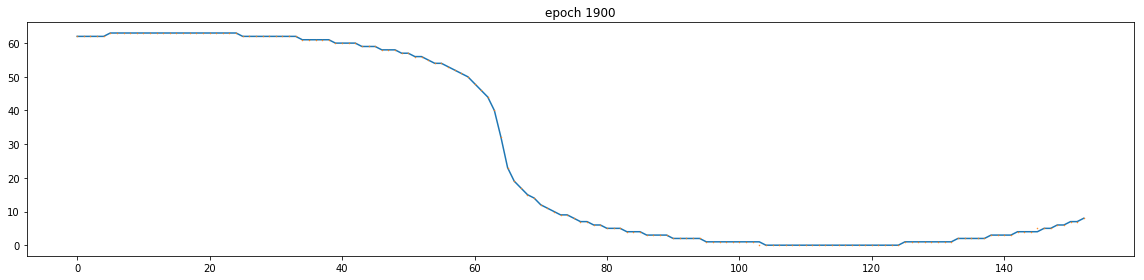

epoch 2000, loss 0.06990770995616913


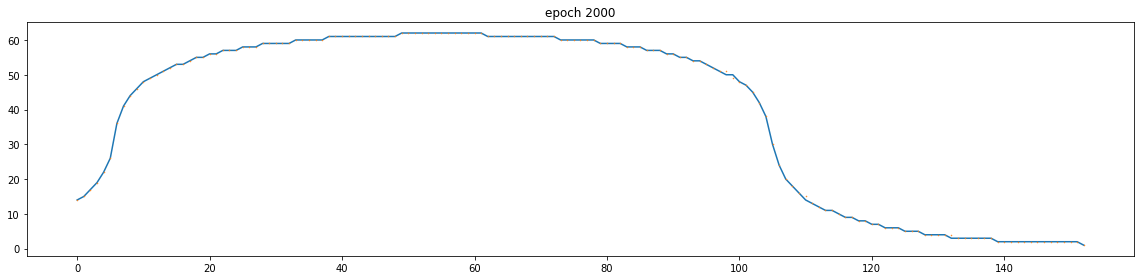

epoch 2100, loss 0.06530649214982986


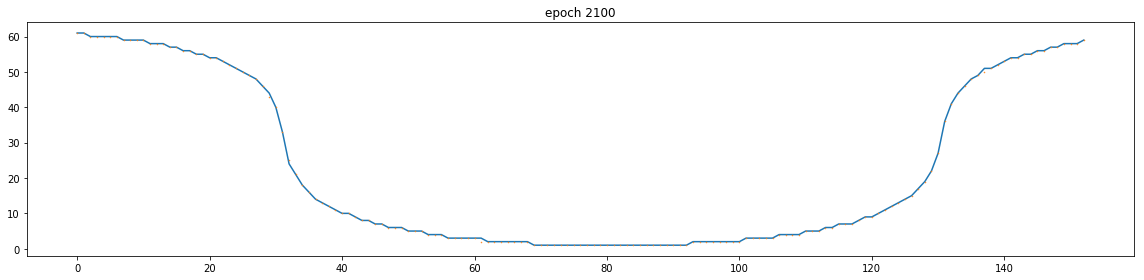

epoch 2200, loss 0.0606190450489521


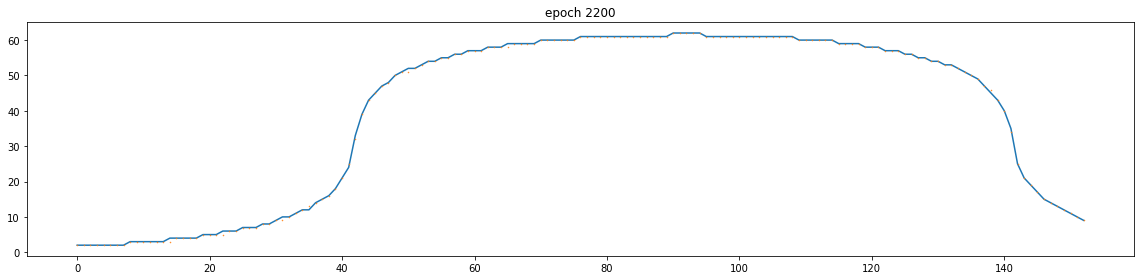

epoch 2300, loss 0.0702405720949173


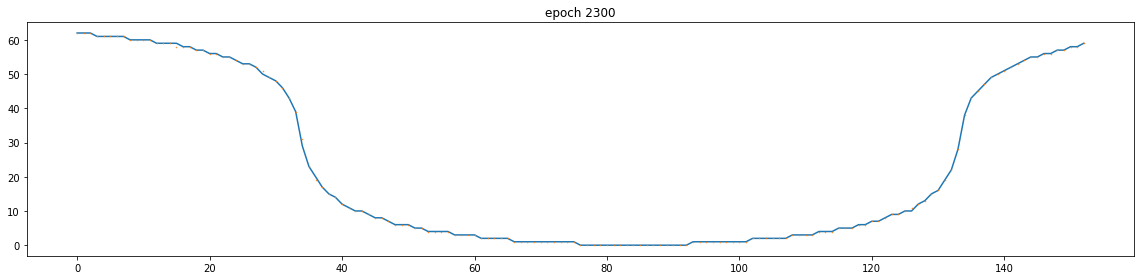

epoch 2400, loss 0.0690792128443718


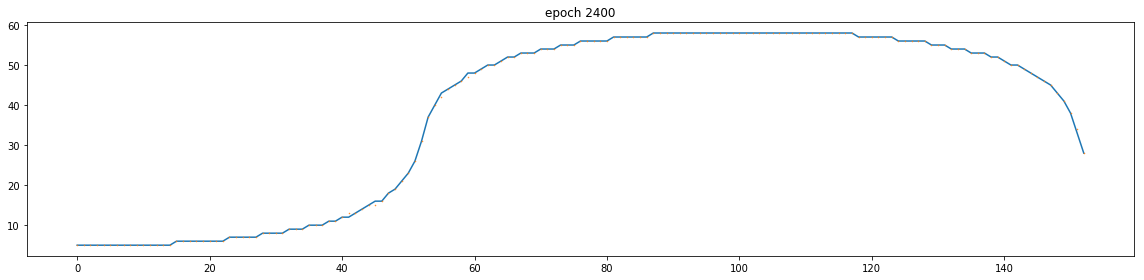

epoch 2500, loss 0.06507311016321182


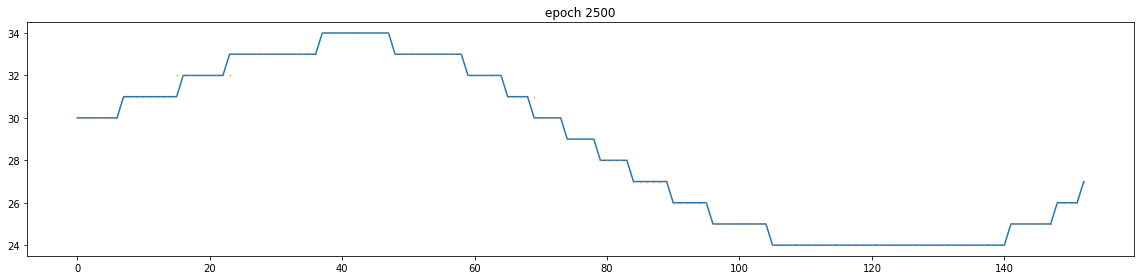

epoch 2600, loss 0.0710546225309372


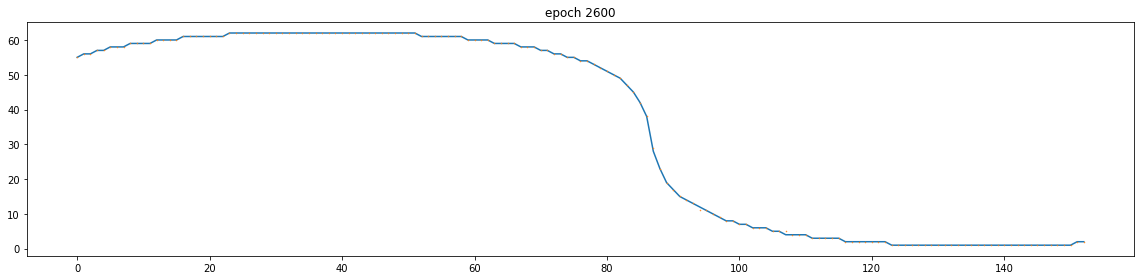

epoch 2700, loss 0.06809011101722717


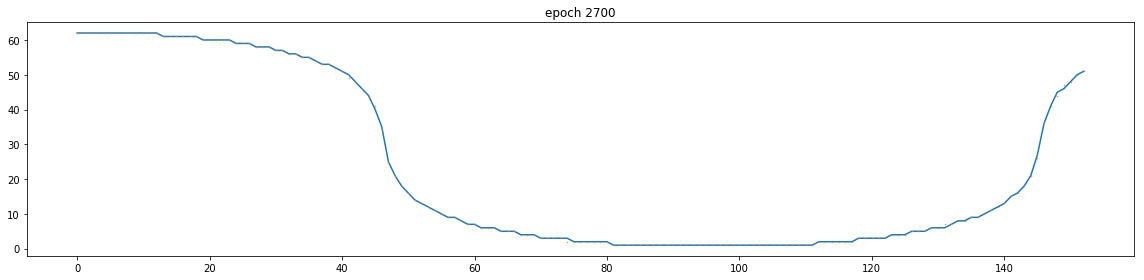

epoch 2800, loss 0.07159663736820221


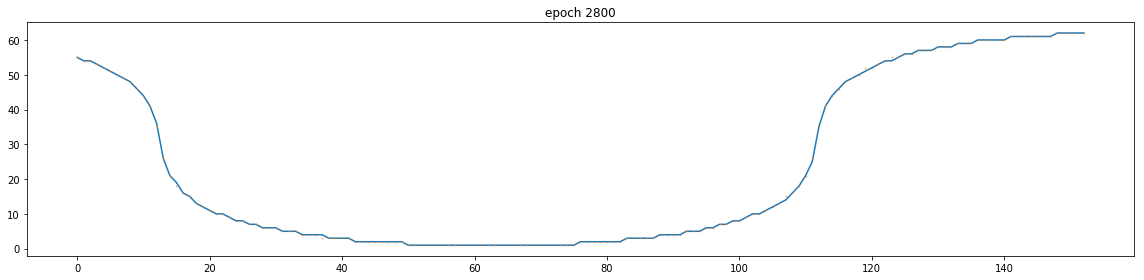

epoch 2900, loss 0.07665731757879257


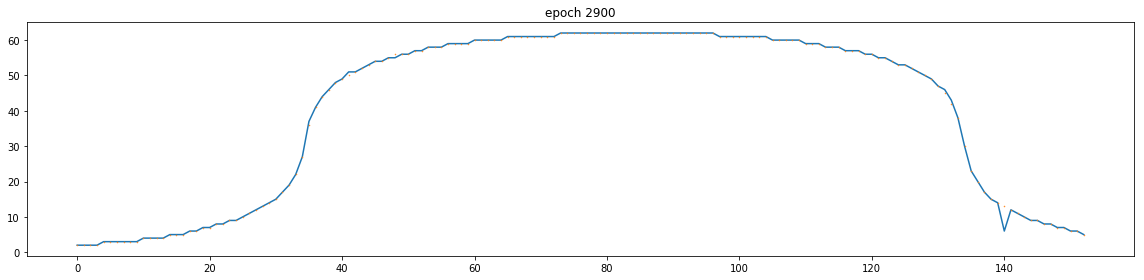

In [9]:
net = WaveNet(mu=64,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.cuda()
optimizer = optim.Adam(net.parameters(),lr=0.01)
g = sine_generator(seq_size=2200,mu=64)
batch_size = 64

loss_save = []
max_epoch = 3000
for epoch in range(max_epoch):
    optimizer.zero_grad()
    loss = 0
    for _ in range(batch_size):
        batch = next(g)
        x = batch[:-1]
        logits = net(x)
        sz = logits.size(0)
        loss += nn.functional.cross_entropy(logits, batch[-sz:].cuda())
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    # monitor progress
    if epoch%100==0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        logits = net(batch[:-1])
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(batch.data.tolist()[sum(net.dilations)+1:],'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()

## loss function

Text(0.5,1,'loss function')

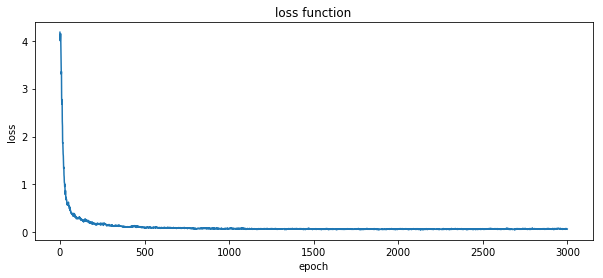

In [10]:
plt.figure(figsize=[10,4])
plt.plot(loss_save)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss function')

## data generation

In [11]:
%time y_gen = net.generate(batch, 4000)

CPU times: user 47.1 s, sys: 927 ms, total: 48.1 s
Wall time: 47.9 s


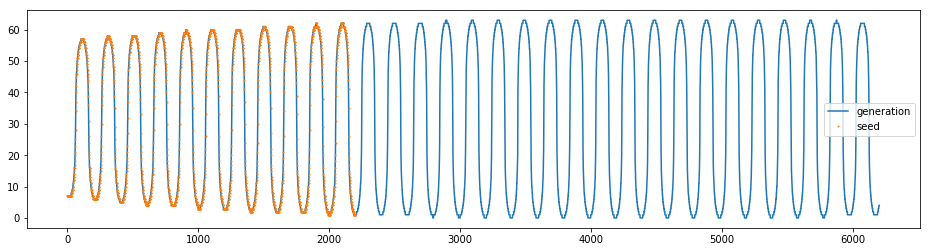

In [12]:
plt.figure(figsize=[16,4])
plt.plot(y_gen)
plt.plot(batch.data.tolist(),'.',ms=2)
plt.legend(['generation','seed'])

## listen to generated sample

In [13]:
%time y_gen = net.generate(batch, 10000)

CPU times: user 1min 58s, sys: 1.78 s, total: 1min 59s
Wall time: 1min 59s


In [14]:
y = np.array(y_gen)
y = decode_mu_law(y, 64)
Audio(y, rate=44100)